In [5]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file
# GP-melt 1.0
import matplotlib.pyplot as plt
import numpy as np
import gpytorch
import torch

import pandas as pd
import numpy as np

import gpvisc

# CPU or GPU?
device = gpvisc.get_device()

Will run on cuda


## Load model and data

In [6]:
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)


In [7]:
print("Loading the viscosity datasets...")
ds = gpvisc.data_loader()
print("Loaded.")

# Here we reconstruct an X axis with T, P and oxide fractions
# for T, we actually use 1000/T because 
# viscosity tends toward -4.5 when 1/T tends toward 0,
# in addition 1000/T values are around unity so this scales the T axis ;
# Custom scaling for P too, we use P/30 as this varies between 0 and 1 ;
# mol fractions of oxides vary between 0 and 1 too so well scaled.
X_train = np.concatenate((1000.0/ds.T_train, ds.P_train/30.0, ds.X_train[:,0:12]), axis=1).copy()
X_valid = np.concatenate((1000.0/ds.T_valid, ds.P_valid/30.0, ds.X_valid[:,0:12]), axis=1).copy()
X_test  = np.concatenate((1000.0/ds.T_test,  ds.P_test/30.0,  ds.X_test[:,0:12]),  axis=1).copy()

# Get outputs
Y_train = torch.FloatTensor(ds.y_train.ravel().copy()).to(device)
Y_valid = torch.FloatTensor(ds.y_valid.ravel().copy()).to(device)
Y_test  = torch.FloatTensor(ds.y_test.ravel().copy()).to(device)

# we perform copies to be sure.
X_train = torch.FloatTensor(X_train.copy()).to(device)
X_valid = torch.FloatTensor(X_valid.copy()).to(device)
X_test = torch.FloatTensor(X_test.copy()).to(device)
# we don't need a validation dataset anymore as
# we tuned everything
# we thus glue the training and validation datasets
# together for the final GP training
X_train_valid = torch.concatenate((X_train,X_valid)).clone().to(device)
Y_train_valid = torch.concatenate((Y_train,Y_valid)).clone().to(device).ravel()

Loading the viscosity datasets...
Loaded.


### Assess performance

In [9]:
y_train_preds, y_train_preds_ese = gpvisc.predict(X_train_valid, gp_model, likelihood, device=device)
y_test_preds, y_test_preds_ese = gpvisc.predict(X_test, gp_model, likelihood, device=device)

from sklearn.metrics import root_mean_squared_error, median_absolute_error, r2_score

print("##########################")
print("The training-validation RMSE is of {:.2f}".format(root_mean_squared_error(Y_train_valid.cpu().detach().numpy(), 
                                                                  y_train_preds)))
print("The test RMSE is of {:.2f}".format(root_mean_squared_error(Y_test.cpu().detach().numpy(), 
                                                                  y_test_preds)))
print("##########################")

print("##########################")
print("The training-validation R2 is of {:.3f}".format(r2_score(Y_train_valid.cpu().detach().numpy(), 
                                                                  y_train_preds)))
print("The test R2 is of {:.3f}".format(r2_score(Y_test.cpu().detach().numpy(), 
                                                                  y_test_preds)))
print("##########################")

print("##########################")
print("The training-validation median absolute error is of {:.3f}".format(median_absolute_error(Y_train_valid.cpu().detach().numpy(), 
                                                                  y_train_preds)))
print("The test median absolute error is of {:.3f}".format(median_absolute_error(Y_test.cpu().detach().numpy(), 
                                                                  y_test_preds)))
print("##########################")

/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


##########################
The training-validation RMSE is of 0.35
The test RMSE is of 0.44
##########################
##########################
The training-validation R2 is of 0.994
The test R2 is of 0.990
##########################
##########################
The training-validation median absolute error is of 0.121
The test median absolute error is of 0.150
##########################


### Speed test

On the first 10 

In [5]:
%%timeit
gpvisc.predict(X_test[:10,:], gp_model, likelihood, device="cuda")

11.1 ms ± 38.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Temperature extrapolation

Now we test predictions on two given data subsets.

We test to predict the viscosity of albite and peridotite melts.

We want to observe if extrapolation toward infinite temperatures tend to converge to a common limit, as people actually say.

We will use also the VFT equation with a high temperature limit at -4.5, we can compare this with results from GP.

In the figure below, we see that the blue curves tend toward -4.5.

The red ones do not.

In [24]:
# Getting the experimental datapoints from the database
ab_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="NAK75_12_0")|
                     (ds.dataset_lp.Name_publi=="Ab")|(ds.dataset_lp.Name_publi=="An0"),:].reset_index()
pr_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Pr"),:].reset_index()

# getting the good dataframes for queries using the helper function generate_query_single
Inputs_ab = gpvisc.generate_query_single(sio2=75.0,
                                         al2o3=12.5,
                                         na2o=12.5,
                                         composition_mole=True,
                                         control_redox=False,
                                         T_init=850.,
                                         T_final=6000.,
                                         P_init=0.0,
                                         P_final = 0.0,
                                         nb_values=2000)

Inputs_pr = gpvisc.generate_query_single(sio2=pr_.loc[0,"sio2"],
                                         tio2=pr_.loc[0,"tio2"],
                                         al2o3=pr_.loc[0,"al2o3"],
                                         feo=pr_.loc[0,"feo"],
                                         fe2o3=pr_.loc[0,"fe2o3"],
                                         mno=pr_.loc[0,"mno"],
                                         na2o=pr_.loc[0,"na2o"],
                                         k2o=pr_.loc[0,"k2o"],
                                         mgo=pr_.loc[0,"mgo"],
                                         cao=pr_.loc[0,"cao"],
                                         p2o5=pr_.loc[0,"p2o5"],
                                         h2o=pr_.loc[0,"h2o"],
                                         composition_mole=True,
                                         control_redox=False,
                                         T_init=900.,
                                         T_final=6000.,
                                         P_init=0.0,
                                         P_final = 0.0,
                                         nb_values=2000)

Inputs_ab_scaled = gpvisc.scale_for_gaussianprocess(Inputs_ab["T"], 
                                                    Inputs_ab["P"], 
                                                    Inputs_ab[gpvisc.list_oxides()])

Inputs_pr_scaled = gpvisc.scale_for_gaussianprocess(Inputs_pr["T"], 
                                                    Inputs_pr["P"], 
                                                    Inputs_pr[gpvisc.list_oxides()])


Text(0, 0.5, 'Viscosity, log Pa s')

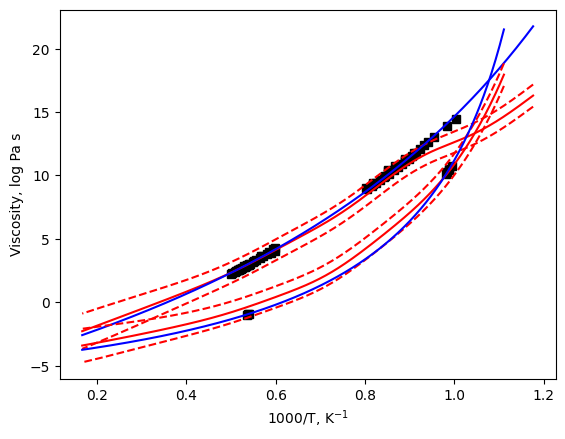

In [25]:
# now we calculate the parameters for the VFT equations of the two melts
def VFT(x,B,C):
    return -4.5 + B/(x-C)

from scipy.optimize import curve_fit
pinit = [5000, 500]
popt_ab, pcov_ab = curve_fit(VFT, ab_["T"], ab_.viscosity,p0=pinit)
popt_peridotite, pcov_peridotite = curve_fit(VFT, pr_["T"], pr_.viscosity,p0=pinit)

#
# GP predictions
#
ab_predictive_mean, ab_predictive_std = gpvisc.predict(Inputs_ab_scaled, gp_model, likelihood, device=device)
ab_lower = ab_predictive_mean-2*ab_predictive_std
ab_upper = ab_predictive_mean+2*ab_predictive_std

pr_predictive_mean, pr_predictive_std = gpvisc.predict(Inputs_pr_scaled, gp_model, likelihood, device=device)
pr_lower = pr_predictive_mean-2*pr_predictive_std
pr_upper = pr_predictive_mean+2*pr_predictive_std

#
# And final figure !
#
T_interest = Inputs_ab["T"]
plt.plot(1000/ab_["T"], ab_["viscosity"],"ks", label="data Ab")
plt.plot(1000/Inputs_ab["T"], ab_predictive_mean,"r-")
plt.plot(1000/Inputs_ab["T"], ab_lower,"r--")
plt.plot(1000/Inputs_ab["T"], ab_upper,"r--")
plt.plot(1000/Inputs_ab["T"], VFT(Inputs_ab["T"], *popt_ab),"b-", label="VFT Ab")

plt.plot(1000/pr_["T"], pr_["viscosity"],"ks",label="data Pr")
plt.plot(1000/Inputs_pr["T"], pr_predictive_mean,"r-")
plt.plot(1000/Inputs_pr["T"], pr_lower,"r--")
plt.plot(1000/Inputs_pr["T"], pr_upper,"r--")
plt.plot(1000/Inputs_pr["T"], VFT(Inputs_pr["T"], *popt_peridotite),"b-", label="VFT Pr")

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")

# Pressure extrapolation

/tmp/ipykernel_258788/2888839413.py:35: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.fill_between(Inputs_ab_hp["P"].ravel(),
/tmp/ipykernel_258788/2888839413.py:35: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.fill_between(Inputs_ab_hp["P"].ravel(),
/tmp/ipykernel_258788/2888839413.py:35: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.fill_between(Inputs_ab_hp["P"].ravel(),


Text(0, 0.5, 'Viscosity, log Pa s')

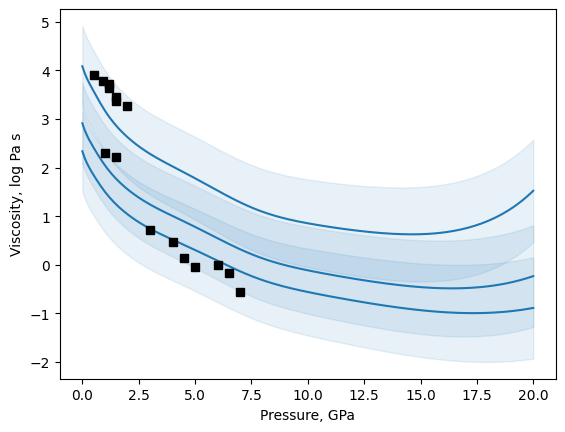

In [29]:
P_interest = np.arange(0,20.,0.5)

dataset_albite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="albite",:].reset_index()

# get the good oxydes and put everything to 100
xi_ = gpvisc.chimie_control(dataset_albite.loc[:, gpvisc.list_oxides()]).values

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(P_interest),xi_.shape[1]))*xi_[0,:]

# Albite dataset
for i in [1873, 1673, 2000]:
    T_interest = i*np.ones(len(P_interest))

    Inputs_ab_hp = gpvisc.generate_query_single(sio2=75.0,
                                                al2o3=12.5,
                                                na2o=12.5,
                                                composition_mole=True,
                                                T_init=i,
                                                T_final=i,
                                                P_init=0.0,
                                                P_final = 20.0,
                                                nb_values=200)

    # transformation
    ptxi_scaled = gpvisc.scale_for_gaussianprocess(Inputs_ab_hp["T"], Inputs_ab_hp["P"], Inputs_ab_hp[gpvisc.list_oxides()])

    # predictions
    ab_p_mean, ab_p_std = gpvisc.predict(ptxi_scaled, gp_model, likelihood, device=device)
    ab_p_lower = ab_p_mean - 2*ab_p_std
    ab_p_upper = ab_p_mean + 2*ab_p_std
    
    # add plot
    plt.plot(Inputs_ab_hp["P"], ab_p_mean,color="C0",linestyle="-")
    plt.fill_between(Inputs_ab_hp["P"].ravel(), 
                     ab_p_lower,
                     ab_p_upper,
                     color="C0", alpha=0.1)

plt.plot(dataset_albite["P"], dataset_albite["viscosity"], "ks")

plt.xlabel("Pressure, GPa")
plt.ylabel("Viscosity, log Pa s")


# Comparing outputs from the three models

In [30]:
# load the other 2 models
gp_model2, likelihood2 = gpvisc.load_gp_model(model_number=2, device=device)
gp_model3, likelihood3 = gpvisc.load_gp_model(model_number=3, device=device)


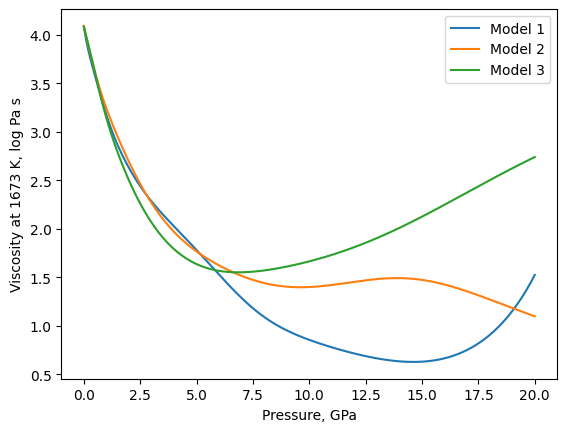

In [32]:
Inputs_ab_hp = gpvisc.generate_query_single(sio2=75.0,
                                            al2o3=12.5,
                                            na2o=12.5,
                                            composition_mole=True,
                                            T_init=1673,
                                            T_final=1673,
                                            P_init=0.0,
                                            P_final = 20.0,
                                            nb_values=200)

# transformation
ptxi_scaled = gpvisc.scale_for_gaussianprocess(Inputs_ab_hp["T"], 
                                               Inputs_ab_hp["P"], 
                                               Inputs_ab_hp[gpvisc.list_oxides()])

# predictions
ab_1_mean, ab_1_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model, likelihood=likelihood, device=device)
ab_2_mean, ab_2_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model2, likelihood=likelihood2, device=device)
ab_3_mean, ab_3_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model3, likelihood=likelihood3, device=device)
    
# add plot
plt.plot(Inputs_ab_hp["P"], ab_1_mean,color="C0",linestyle="-", label="Model 1")
plt.plot(Inputs_ab_hp["P"], ab_2_mean,color="C1",linestyle="-", label="Model 2")
plt.plot(Inputs_ab_hp["P"], ab_3_mean,color="C2",linestyle="-", label= "Model 3")
    
plt.xlabel("Pressure, GPa")
plt.ylabel("Viscosity at 1673 K, log Pa s")
plt.legend()


# Composition extrapolation

We extrapolate compositions at low silica content along the SiO2-Na2O binary. We use the helper function to do this job:

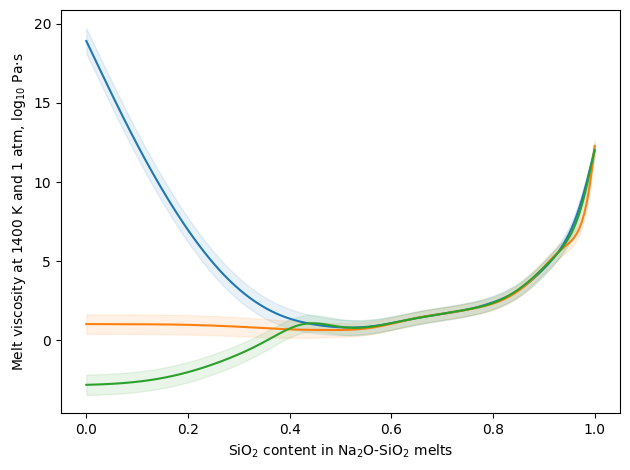

In [33]:
oxide_ranges = {
    'sio2': [100., 0.0],
    'tio2': [0.0, 0.0],
    'al2o3': [0.0, 0.0],
    "feo" :[0.0, 0.0],
    "fe2o3":[0.0,0.0],
    "mno" :[0.0,0.0],
    "na2o":[0.0, 100.],
    "k2o" :[0.0, 0.0],
    "mgo" :[0.0, 0.0],
    "cao" :[0.0, 0.0],
    "p2o5":[0.0, 0.0],
    "h2o" :[0.0, 0.0],
}

Inputs_range = gpvisc.generate_query_range(oxide_ranges, composition_mole=True,
                                    T_init=1400, T_final=1400, P_init=0.0, P_final=0.0,
                                    nb_values=200)

# transformation
ptxi_scaled = gpvisc.scale_for_gaussianprocess(Inputs_range["T"], 
                                               Inputs_range["P"], 
                                               Inputs_range[gpvisc.list_oxides()])

# predictions
NS_1_mean, NS_1_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model, likelihood=likelihood, device=device)
NS_2_mean, NS_2_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model2, likelihood=likelihood2, device=device)
NS_3_mean, NS_3_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model3, likelihood=likelihood3, device=device)

plt.plot(Inputs_range["sio2"], NS_1_mean,"-", color="C0", label="Model 1")
plt.plot(Inputs_range["sio2"], NS_2_mean,"-", color="C1", label="Model 2")
plt.plot(Inputs_range["sio2"], NS_3_mean,"-", color="C2", label="Model 3")
plt.fill_between(Inputs_range["sio2"], 
                 NS_1_mean - NS_1_std,
                 NS_1_mean + NS_1_std,
                 alpha=0.1, color="C0")

plt.fill_between(Inputs_range["sio2"], 
                 NS_2_mean - NS_2_std,
                 NS_2_mean + NS_2_std,
                 alpha=0.1, color="C1")

plt.fill_between(Inputs_range["sio2"], 
                 NS_3_mean - NS_3_std,
                 NS_3_mean + NS_3_std,
                 alpha=0.1, color="C2")

plt.xlabel("SiO$_2$ content in Na$_2$O-SiO$_2$ melts")
plt.ylabel("Melt viscosity at 1400 K and 1 atm, log$_{10}$ Pa$\cdot$s")
plt.tight_layout()

### Aqueous fluids

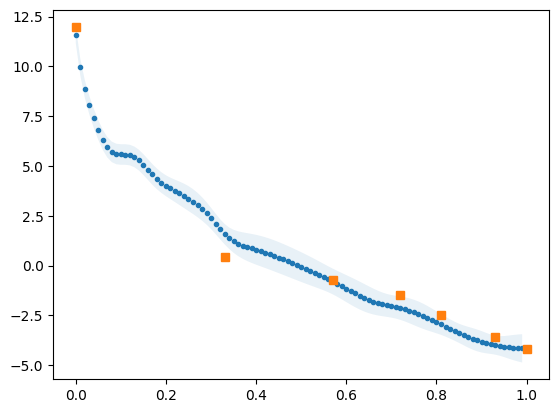

In [35]:
h2o_range = np.arange(0,1,0.01)
ds_ = pd.DataFrame({"sio2":h2o_range*0.0+(1-h2o_range)*0.75,
                      "al2o3":h2o_range*0.0+(1-h2o_range)*0.125,
                      "na2o":h2o_range*0.0+(1-h2o_range)*0.125,
                      "k2o":h2o_range*0.0+(1-h2o_range)*0.0,
                      "cao":h2o_range*0.0+(1-h2o_range)*0.0,
                      "h2o":h2o_range,})

# add elements that are 0
ds_ = gpvisc.chimie_control(ds_)

# add descriptors
xi = gpvisc.chimie_control(ds_.loc[:, gpvisc.list_oxides()])
T_interest = 1073.0 * np.ones(len(ds_))
P_interest = 0.0 * np.ones(len(ds_))

# transformation
ptxi_scaled = gpvisc.scale_for_gaussianprocess( 
                               T_interest.reshape(-1,1), 
                               P_interest.reshape(-1,1),xi)

# predictions
visco_mean, visco_std = gpvisc.predict(ptxi_scaled, gp_model=gp_model, likelihood=likelihood, device=device)
visco_lower = visco_mean - visco_std
visco_upper = visco_mean + visco_std

ab_mol_eau_ = [0,0.33,0.57,0.72,0.81,0.93,1.0]
ab_visco_eau_ = [11.97, 0.44, -0.71, -1.50, -2.49, -3.56, -4.21] 
plt.plot(h2o_range, visco_mean,".")
plt.fill_between(h2o_range, 
                 visco_lower,
                 visco_upper,
                 alpha=0.1)

# data from Audétat and Keppler
plt.plot(ab_mol_eau_, ab_visco_eau_, "s")